In [1]:
!pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=e3d11481c1b2ed41230b996e2df8662ffbd24446ed110bda4ca0627f0a0c1292
  Stored in directory: /root/.cache/pip/wheels/54/4a/75/06b8e63fce6f6d2c1baae5c208edb18eca128407b0c96e1153
Successfully built pandas_ta


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta

In [3]:
btc_df = pd.read_csv('btc_df.csv')  

In [4]:
btc_df = btc_df.drop(columns=['closeTime','quoteAssetVolume','numberOfTrades','takerBuyBaseVol','takerBuyQuoteVol','ignore'])
btc_df

,dateTime,open,high,low,close,volume
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...,...
1931,2022-11-30,16442.91,17249.00,16428.30,17163.64,303019.807190
1932,2022-12-01,17165.53,17324.00,16855.01,16977.37,232818.182180
1933,2022-12-02,16978.00,17105.73,16787.85,17092.74,202372.206200
1934,2022-12-03,17092.13,17188.98,16858.74,16885.20,154542.573060


In [5]:
btc_df = btc_df.drop(columns=['open', 'high', 'low', 'volume'])
btc_df

,dateTime,close
0,2017-08-17,4285.08
1,2017-08-18,4108.37
2,2017-08-19,4139.98
3,2017-08-20,4086.29
4,2017-08-21,4016.00
...,...,...
1931,2022-11-30,17163.64
1932,2022-12-01,16977.37
1933,2022-12-02,17092.74
1934,2022-12-03,16885.20


In [6]:
btc_df['dateTime'] = pd.to_datetime(btc_df['dateTime'])

In [7]:
# Adding indicators
btc_df['RSI']=ta.rsi(btc_df.close, length=15)
btc_df['EMA50']=ta.ema(btc_df.close, length=50)
btc_df['EMA200']=ta.ema(btc_df.close, length=200)

btc_df.dropna(inplace=True)

In [8]:
btc_df = btc_df.reset_index().drop(columns=['index'])

In [9]:
btc_df

,dateTime,close,RSI,EMA50,EMA200
0,2018-03-04,11515.00,58.711376,10645.559733,8756.490300
1,2018-03-05,11454.00,58.151919,10677.263273,8783.331193
2,2018-03-06,10716.48,51.762420,10678.801184,8802.566504
3,2018-03-07,9910.00,45.858920,10648.652118,8813.585743
4,2018-03-08,9271.64,41.814492,10594.651643,8818.143497
...,...,...,...,...,...
1732,2022-11-30,17163.64,48.389459,18018.979182,23143.555031
1733,2022-12-01,16977.37,46.634408,17978.131763,23082.199956
1734,2022-12-02,17092.74,47.888659,17943.410517,23022.603340
1735,2022-12-03,16885.20,45.813330,17901.912066,22961.534650


# shifting window and normalize data to train 

In [61]:
btc_raw_df = btc_df.copy()

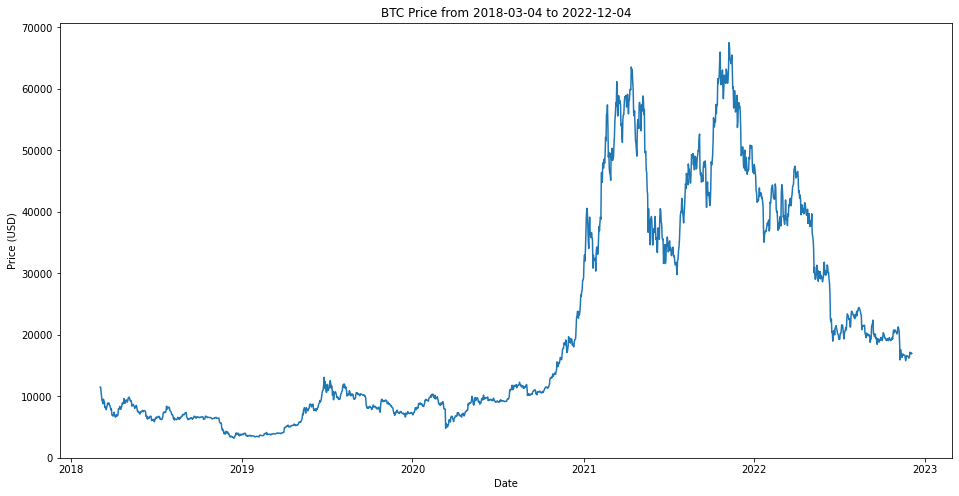

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(btc_raw_df['dateTime'], btc_raw_df['close'])
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.title('BTC Price from ' + str(min(btc_raw_df['dateTime']))[:10] + ' to ' + str(max(btc_raw_df['dateTime']))[:10])
plt.show()

In [64]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers

from keras.layers import Activation
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler

For each train set (e.g. from t=0 to t=5 in red - train set 1), you want to predict the following H time steps (corresponding to t=6 in orange - test set 1). In this, your horizon is simply one i.e. H=1.

Basic sketch of a rolling out-of-sample forecast

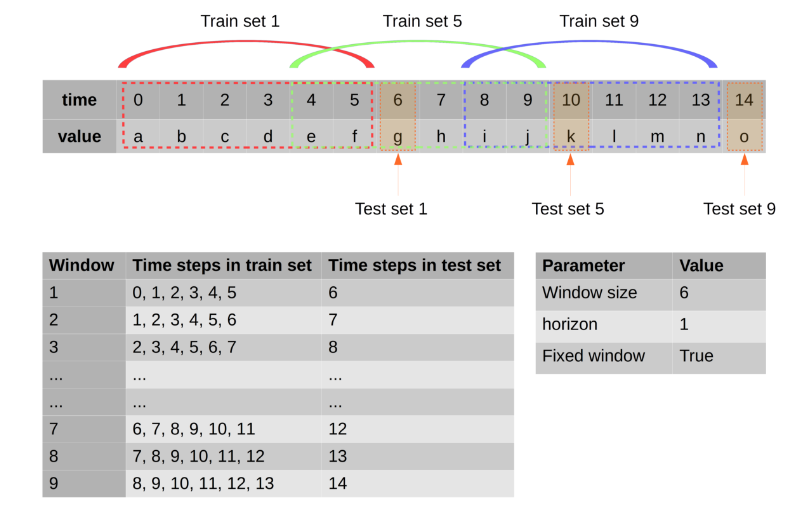

Let's say you would like to predict the next 10 days, meaning you need H=10.

In [62]:
testing_window = 31     
x_window = 4            
time_shift = 1             

In [63]:
train_idx = int((len(btc_raw_df) - testing_window - x_window)*0.8) + x_window
sc = StandardScaler().fit(btc_raw_df.iloc[:train_idx, 1:])
btc_raw_df.iloc[:, 1:] = sc.transform(btc_raw_df.iloc[:, 1:])

In [65]:
datetime_list = btc_raw_df.dateTime
btc_raw_df = btc_raw_df.iloc[:, 1:]

X = np.zeros((len(btc_raw_df)-x_window-time_shift+1, len(btc_raw_df.columns), x_window))
Y = np.zeros((len(btc_raw_df)-x_window-time_shift+1, len(btc_raw_df.columns), 1))
for i in range(X.shape[0]):
    X[i] = np.array(btc_raw_df.iloc[i:i+x_window]).T
    Y[i] = np.array(btc_raw_df.loc[i+x_window+time_shift-1])[:,np.newaxis]

In [66]:
X_train = X[:-testing_window]
Y_train = Y[:-testing_window]
X_test = X[-testing_window:]
Y_test = Y[-testing_window:]
val_idx = int(X_train.shape[0]*0.8)
X_val = X_train[val_idx:]
Y_val = Y_train[val_idx:]
X_train = X_train[:val_idx]
Y_train = Y_train[:val_idx]

 The model consists of 3 layers:

- LSTM layer with 128 units, sigmoid activation, set to return sequences and with L2 regularization with a strength of 0.01.
- Dropout layer with rate 0.2 to prevent overfitting
- Dense layer with 1 unit, no activation function specified (defaults to linear).

The model is compiled with mean squared error as the loss function, the Adam optimizer, and mean absolute error as a metric. The code also sets up an early stopping callback that monitors the validation loss and stops training after 30 epochs without improvement. Finally, the model is fit on the training data for a maximum of 100 epochs, with validation data and a batch size of 16. The verbose argument is set to 1, which means the training progress will be displayed in the console.

In [79]:
model = keras.Sequential([
    layers.LSTM(64, input_shape=X.shape[1:], activation="tanh", return_sequences=True,  kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(1)])

model.compile(loss='mean_squared_error', optimizer=optimizers.RMSprop(), metrics='mean_absolute_error')
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_val, Y_val), shuffle=True, batch_size=16, verbose=1, callbacks=[callback])

Epoch 1/100
86/86 [==============================] - 2s 10ms/step - loss: 0.4063 - mean_absolute_error: 0.4181 - val_loss: 0.1343 - val_mean_absolute_error: 0.1988
Epoch 2/100
86/86 [==============================] - 0s 5ms/step - loss: 0.0898 - mean_absolute_error: 0.1362 - val_loss: 0.0715 - val_mean_absolute_error: 0.1421
Epoch 3/100
86/86 [==============================] - 0s 5ms/step - loss: 0.0635 - mean_absolute_error: 0.1205 - val_loss: 0.0542 - val_mean_absolute_error: 0.1224
Epoch 4/100
86/86 [==============================] - 0s 5ms/step - loss: 0.0538 - mean_absolute_error: 0.1133 - val_loss: 0.0497 - val_mean_absolute_error: 0.1284
Epoch 5/100
86/86 [==============================] - 0s 5ms/step - loss: 0.0500 - mean_absolute_error: 0.1097 - val_loss: 0.0442 - val_mean_absolute_error: 0.1010
Epoch 6/100
86/86 [==============================] - 0s 5ms/step - loss: 0.0467 - mean_absolute_error: 0.1061 - val_loss: 0.0405 - val_mean_absolute_error: 0.1051
Epoch 7/100
86/86 [==

The hyperbolic tangent (tanh) activation function is commonly used in RNN models because it maps any real-valued number to the range (-1, 1). This makes it useful for processing data with a range of values, such as financial time series data.

The tanh function has the advantage of being non-linear, meaning it can capture complex relationships in the data that linear activation functions cannot. Additionally, the range of the tanh function makes it easier to control the magnitude of the output, which can be important in time series prediction where the output should be within a certain range (e.g. the price of a stock or cryptocurrency).

In general, the choice of activation function is dependent on the specific problem you are trying to solve, and there is no single "best" activation function for all use cases. The tanh activation is a good starting point for RNN models, but it is always good to try other activation functions as well and compare their performance.

---

In [80]:
Y_pred = model.predict(X_test)[:, :, 0]
pred_df = pd.DataFrame(sc.inverse_transform(Y_pred), index=list(datetime_list[-len(Y_pred):]))
pred_df = pred_df.rename_axis('dateTime').reset_index()
pred_df.head()

1/1 [==============================] - 0s 368ms/step


,dateTime,0,1,2,3
0,2022-11-04,20892.478516,54.303028,20622.585938,25510.056641
1,2022-11-05,21720.357422,62.674843,20523.582031,25414.695312
2,2022-11-06,21954.216797,64.767189,20584.146484,25412.818359
3,2022-11-07,21621.669922,59.966480,20752.386719,25442.833984
4,2022-11-08,21324.326172,55.978687,20836.041016,25433.068359


there are several ways to enhance the model for cryptocurrency price prediction:

- Adding more LSTM or other types of RNN layers to increase the model's capacity to capture complex relationships in the data.
- Using more recent historical data for input, such as the latest price, volume, and technical indicators.
- Adding attention mechanism to the LSTM layer, which allows the model to focus on the most relevant part of the input sequence.
- Using a different optimizer that is better suited for time series data, such as the RMSprop optimizer.
- Incorporating other types of data, such as news articles and social media posts, which can provide valuable information about market sentiment.
- Using a different loss function, such as the mean absolute percentage error (MAPE), which is more interpretable in the context of financial prediction.
- Using a different evaluation metric, such as the Sharpe ratio, which measures the return per unit of risk for an investment.

It's important to keep in mind that, regardless of the enhancements, the model may still have limitations in accurately predicting cryptocurrency prices, as the market is highly dynamic and influenced by various factors beyond the data used for training.

In [81]:
temp_df = btc_df.iloc[-150:-3]
temp_df.head()
pred_df.head()

,dateTime,0,1,2,3
0,2022-11-04,20892.478516,54.303028,20622.585938,25510.056641
1,2022-11-05,21720.357422,62.674843,20523.582031,25414.695312
2,2022-11-06,21954.216797,64.767189,20584.146484,25412.818359
3,2022-11-07,21621.669922,59.966480,20752.386719,25442.833984
4,2022-11-08,21324.326172,55.978687,20836.041016,25433.068359


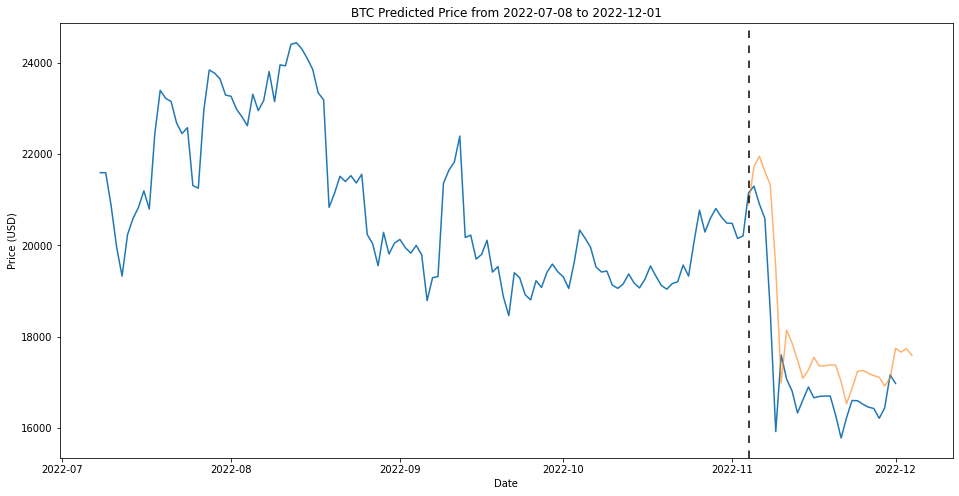

In [82]:
plt.figure(figsize=(16,8))
plt.plot(temp_df['dateTime'], temp_df['close'])
plt.plot(pred_df['dateTime'], pred_df[0], alpha = 0.6)
# add verticle reference line
plt.axvline(x=min(pred_df['dateTime']), color='k', linestyle=(0, (5, 5)))
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.title('BTC Predicted Price from ' + str(min(temp_df['dateTime']))[:10] + ' to ' + str(max(temp_df['dateTime']))[:10])
plt.show()    

In [ ]:
print(temp_df.shape)
print(pred_df.shape)
df = pd.merge(temp_df, pred_df, on='dateTime', how='outer')
df

(147, 5)
(61, 5)


,dateTime,close,RSI,EMA50,EMA200,0,1,2,3
0,2022-07-08,21594.75,46.175438,24710.481927,35043.244435,NaN,NaN,NaN,NaN
1,2022-07-09,21591.83,46.158469,24588.181851,34909.399515,NaN,NaN,NaN,NaN
2,2022-07-10,20862.47,42.025244,24442.075504,34769.629072,NaN,NaN,NaN,NaN
3,2022-07-11,19963.61,37.581720,24266.449406,34622.305499,NaN,NaN,NaN,NaN
4,2022-07-12,19328.75,34.797435,24072.814135,34470.130818,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
145,2022-11-30,17163.64,48.389459,18018.979182,23143.555031,16459.847656,40.215912,17990.890625,23240.804688
146,2022-12-01,16977.37,46.634408,17978.131763,23082.199956,17177.810547,48.097057,18157.640625,23013.701172
147,2022-12-02,NaN,NaN,NaN,NaN,17033.587891,46.932514,17862.642578,22912.664062
148,2022-12-03,NaN,NaN,NaN,NaN,17102.732422,47.675919,17786.332031,22832.292969


In [ ]:
import pickle

pickle.dump(model, open('./models/model_BTC.pkl', 'wb'))

In [ ]:
df.to_csv('./data/pred/BTC_PRED.csv') 